# **Pràctica 4**

# Entrenament de models de Word2Vec

In [5]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

Importem el dataset de la manera en la que s'indica a la pàgina web.

In [2]:
from datasets import load_dataset

dataset = load_dataset("projecte-aina/catalan_general_crawling")

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for projecte-aina/catalan_general_crawling contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/projecte-aina/catalan_general_crawling
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Observem que en el dataset hi ha una part de train, per tant obtenim aquesta part anomenant-la train_dataset, i observem que el contingut de text es troba a la columna 'text' de train_dataset

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1016113
    })
})

In [4]:
train_dataset = dataset['train']

In [8]:
train_dataset

Dataset({
    features: ['text'],
    num_rows: 1016113
})

Definim una funció per preprocessar el dataset. Aquesta funció neteja i normalitza el text, convertint-lo tot a minúscules, eliminant caràcters especials, i dividint-lo en paraules abans de tornar-lo a unir en un sol string.

In [36]:
import os
import re
from nltk.tokenize import word_tokenize

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    tokens = word_tokenize(text)
    return ' '.join(tokens)

A continuació es defineix una funció que s'utilitza per dividir el conjunt de dades en diverses parts i realitzar el preprocessament a cada part. Pren com a parametres d'entrada el conjunt de dades a preprocessarm el directori on es guradaran els arxius dividits i una llista de mides desitjades per cada part (en bytres), i com a sortida s'obté arxius de text preprocessats, dividits segons les mides especificades i guardats al directori de sortida.

Explicació del contingut de la funció:
- Es crea un directori de sortida, en cas de que no existeixi, per assegurar que es poden guardar els arxius resultants.
- Es defineixen diverses variables per mantenir el compte de la part que s'està preprocessant, la seva mida i per afegir el text preprocessat.
- S'extreu el text de la fila, es preprocessa utilitzant la funció anterior.
- Si s'arriba a la mida dessitjada, es guarda el text preprocessat a un arxiu de text en el directori de sortida.


In [37]:
def dividir_y_preprocesar_dataset(dataset, output_dir, tamano_partes):
    
    if not os.path.exists(output_dir): 
        os.makedirs(output_dir)
        
    total_bytes = 0
    contador = 1
    current_size = 0
    current_part = []
    
    for i, row in enumerate(dataset):
        text = row['text']
        preprocessed_text = preprocess(text)
        current_size += len(preprocessed_text.encode('utf-8'))
        current_part.append(preprocessed_text)
        
        if current_size >= tamano_partes[contador - 1]:
            with open(os.path.join(output_dir, f'parte_{contador}.txt'), 'w', encoding='utf-8') as f:
                for line in current_part:
                    f.write(line + '\n')
            current_part = []
            current_size = 0
            contador += 1
            
            if contador > len(tamano_partes):
                break

    if current_part:
        with open(os.path.join(output_dir, f'parte_{contador}.txt'), 'w', encoding='utf-8') as f:
            for line in current_part:
                f.write(line + '\n')


Una vegada definida la funció 'dividir_y_preprocesar_dataset', la cridem amb les mides dessitjades (100MB, 500MB i 1GB) i amb el directori de sortida corresponent.

In [38]:
tamano_partes = [100 * 1024 * 1024, 500 * 1024 * 1024, 1 * 1024 * 1024 * 1024] # 100MB, 500MB, 1GB
output_dir = 'divided_datasets'
dividir_y_preprocesar_dataset(train_dataset, output_dir, tamano_partes)

Ara passem a entrenar un model Word2Vec per a cada part del conjunt de dades dividit i preprocessat. 

Primer, es crea una llista de rutes als arxius dividits i preprocessats, per tal de poder accedir als textos i poder entrenar el model amb ells. 

Hem decidit utilitzar LineSentence de gensim per llegir les frases, ja que d'aquesta manera es converteix cada línea en una llista de paraules per a l'entrenament del model Word2vec.

Es crea un model Word2Vec amb els següents paràmetres:
- sentences: les frases preprocesades llegides del fitxer.
- vector_size=100: la dimensió dels vectors de paraules.
- window=5: la mida de la finestra de context.
- min_count=10: només les paraules que apareixen almenys 10 vegades seran considerades.
- workers=4: el nombre de fils per al processament.
- sg=1: utilitzar el model Skip-Gram (en lloc de CBOW).
- epochs=25: nombre d'iteracions sobre el conjunt de dades.

Finalment, el model entrenat es guarda en un fitxer.

In [39]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

dataset_parts = [f'divided_datasets/parte_{i}.txt' for i in range(1, len(tamano_partes) + 1)]

for i, part in enumerate(dataset_parts):
    sentences = LineSentence(part)
    
    model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=10, workers=4, sg=1, epochs=25)
    
    model.save(f'word2vec_model_part_{i+1}.model')

    print(f'Model for part {i+1} trained and saved.')

Model for part 1 trained and saved.
Model for part 2 trained and saved.
Model for part 3 trained and saved.


Després d'entrenar els models, volem comprovar que estiguin funcionant correctament, d'aquesta manera també podem comparar les diferències entre els diferents models amb les diferents mides.

Comprovem les paraules més similars a 'informàtica' i la similitud entre 'informàtica' i 'digital'.

In [ ]:
from gensim.models import Word2Vec

model_paths = [f'word2vec_model_part_{i+1}.model' for i in range(len(tamano_partes))]

for model_path in model_paths:
    model = Word2Vec.load(model_path)

    similar_words = model.wv.most_similar('informàtica', topn=10)
    print("Paraules similars a 'informàtica':")
    for word, similarity in similar_words:
        print(f'{word}: {similarity:.4f}')

    similarity = model.wv.similarity('informàtica', 'coordinador')
    print(f"Similitud entre 'informàtica' i 'coordinador': {similarity:.4f}")

    print('======================================================================')


Paraules similars a 'informàtica':
enginyeria: 0.7088
instrumentació: 0.6706
tecnologia: 0.6700
sig: 0.6690
telecomunicació: 0.6620
ub: 0.6593
aplicacions: 0.6580
informàtic: 0.6461
automàtica: 0.6351
tecnologies: 0.6276
Similitud entre 'informàtica' i 'coordinador': 0.4499
Paraules similars a 'informàtica':
enginyeria: 0.7521
telecomunicació: 0.7449
matemàtiques: 0.7112
multimèdia: 0.7112
informàtiques: 0.7093
fib: 0.6939
robòtica: 0.6871
química: 0.6836
computació: 0.6810
etse: 0.6721
Similitud entre 'informàtica' i 'coordinador': 0.3539
Paraules similars a 'informàtica':
enginyeria: 0.8266
telecomunicació: 0.7946
computació: 0.7443
informàtiques: 0.7199
matemàtiques: 0.7113
enginyeries: 0.7080
upc: 0.7031
robòtica: 0.6991
computadors: 0.6974
màster: 0.6963
Similitud entre 'informàtica' i 'coordinador': 0.3152


ERROR: Exception:
Traceback (most recent call last):
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\http\client.py", line 465, in read
    s = self.fp.read(amt

     ---------------------------------------- 0.0/457.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/457.1 MB ? eta -:--:--
     -------------------------------------- 0.0/457.1 MB 320.0 kB/s eta 0:23:49
     -------------------------------------- 0.0/457.1 MB 320.0 kB/s eta 0:23:49
     -------------------------------------- 0.0/457.1 MB 320.0 kB/s eta 0:23:49
     -------------------------------------- 0.0/457.1 MB 320.0 kB/s eta 0:23:49
     -------------------------------------- 0.0/457.1 MB 320.0 kB/s eta 0:23:49
     --------------------------------------- 0.0/457.1 MB 69.0 kB/s eta 1:50:29
     --------------------------------------- 0.0/457.1 MB 69.0 kB/s eta 1:50:29
     --------------------------------------- 0.0/457.1 MB 69.0 kB/s eta 1:50:29
     --------------------------------------- 0.0/457.1 MB 69.0 kB/s eta 1:50:29
     --------------------------------------- 0.0/457.1 MB 69.0 kB/s eta 1:50:29
     --------------------------------------- 0.0/457.1

Per avaluar els models també hem utilitzat el t-SNE, d'aquesta manera podem visualitzar els Word Embeddings i con canvien depenent de la mida del dataset utilitzat.

In [101]:
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

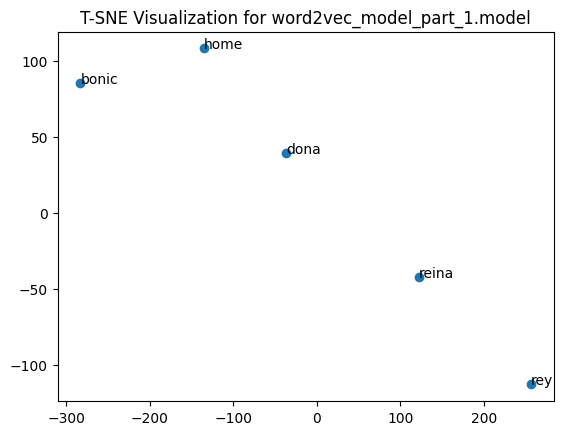

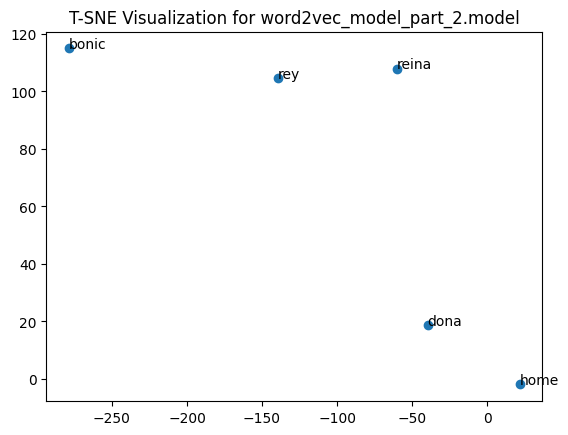

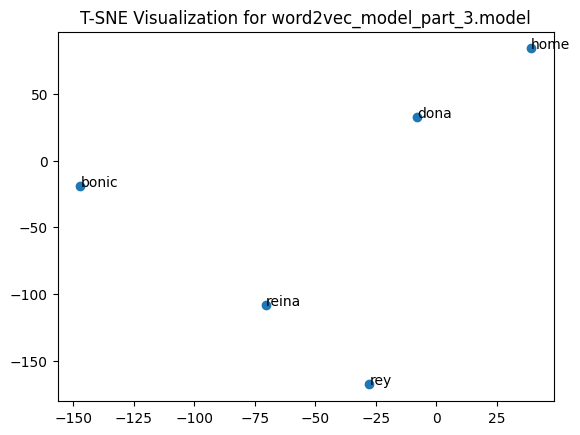

In [106]:
model_paths = [f'word2vec_model_part_{i+1}.model' for i in range(len(tamano_partes))]

vocab = ['home', 'dona', 'reina', 'rey', 'bonic']  # Canviar a les paraules que es vulgui provar

for model_path in model_paths:
    model = Word2Vec.load(model_path)
    X = model.wv[vocab]
    
    tsne = TSNE(n_components=2, perplexity=2, random_state=0)
    X_tsne = tsne.fit_transform(X)
    
    df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
    
    fig, ax = plt.subplots()
    ax.scatter(df['x'], df['y'])
    
    for word, pos in df.iterrows():
        ax.annotate(word, pos)

    ax.set_title(f'T-SNE Visualization for {model_path}')
    plt.show()

# Model de Similitud de Text Semàntic 

In [45]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from gensim.models import Word2Vec
from scipy.stats import pearsonr
from datasets import load_dataset
import re
from nltk.tokenize import word_tokenize
import tensorflow as tf

Per tal d'avaluar els models amb els diferents models d'incrustació de paraules, utilitzem la correlació de pearson. S'ha definit la funció compute_pearson, aquesta funció reb les dadesd d'entrada (x_), les etiquetes reals (y_) i el model que utilitzem per fer les prediccions. Retorna la correlació de Pearson, indicant la força i direcció de la relació linelas entre les prediccions del model i les etiquetes reals.

In [121]:
def compute_pearson(x_, y_, model):
    y_pred = model.predict(x_)
    correlation, _ = pearsonr(y_pred.flatten(), y_.flatten())
    return correlation

El conjunt de dades es carrega utilitzant la funció load_dataset, i es divideix en subconjunts d'entrenament, validació i prova. Posteriorment, es defineix una funció preprocess per convertir el text a minúscules, eliminar caràcters no alfanumèrics i tokenitzar les frases, això facilita l'anàlisi i la comparació semàntica entre les frases. Aquesta funció s'aplica a cada parell de frases i etiquetes en els tres subconjunts de dades.

In [122]:
dataset_ts = load_dataset("projecte-aina/sts-ca")
train_data = dataset_ts['train']
val_data = dataset_ts['validation']
test_data = dataset_ts['test']

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    tokens = word_tokenize(text)
    return tokens

train_data = [(preprocess(s1), preprocess(s2), label) for s1, s2, label in zip(train_data['sentence1'], train_data['sentence2'], train_data['label'])]
val_data = [(preprocess(s1), preprocess(s2), label) for s1, s2, label in zip(val_data['sentence1'], val_data['sentence2'], val_data['label'])]
test_data = [(preprocess(s1), preprocess(s2), label) for s1, s2, label in zip(test_data['sentence1'], test_data['sentence2'], test_data['label'])]


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for projecte-aina/sts-ca contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/projecte-aina/sts-ca
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


## One hot

A continuació realitzarem els embeddings amb One-Hot. Es prepraren les dades, es converteixen en representacions One-Hot, s'entrena el model per predir la similitud semàntica entre parelles de frases i s'avalua el model.

La funció tokenize_sentences pren una llista de frases i retorna una llista de llistes, on cada subllista conté les paraules de la frase corresponent. S'utilitza per tal d'obtenir totes les frases del dataset i dividir-les en paraules.

In [80]:
def tokenize_sentences(data):
    return [[word for word in sentence.split()] for sentence in data]

all_sentences = []
for s1, s2, _ in train_data + val_data + test_data:
    all_sentences.extend([s1, s2])

tokenized_sentences = tokenize_sentences([' '.join(sent) for sent in all_sentences])

Es crea un vocabulari de totes les paraules en les oracions tokenitzades i s'assigna un índex únic a cada paraula del vocabulari.

In [123]:
vocab = list(set(word for sentence in tokenized_sentences for word in sentence))
word_to_index = {word: i for i, word in enumerate(vocab)}

Es defineix la funció sentences_to_indices que converteix una llista d'oracions en una matriu de índexs (cada paraula per el seu índex del diccionri word_to_índex).

In [124]:
def sentences_to_indices(sentences, word_to_index, max_length):
    indices = np.zeros((len(sentences), max_length))
    for i, sentence in enumerate(sentences):
        for j, word in enumerate(sentence.split()[:max_length]):
            indices[i, j] = word_to_index.get(word, 0)
    return indices

A contuncuació es converteix els conjunts de dades de parells d'oracions i les seves labels en matrius d'indexs, de forma que pugui ser utilitzada pel model.

In [125]:
max_length = 50  

def pair_list_to_x_y_onehot(data, word_to_index, max_length):
    X1 = sentences_to_indices([' '.join(s1) for s1, _, _ in data], word_to_index, max_length)
    X2 = sentences_to_indices([' '.join(s2) for _, s2, _ in data], word_to_index, max_length)
    y = np.array([label for _, _, label in data])
    return (X1, X2), y

(x_train_1_onehot, x_train_2_onehot), y_train = pair_list_to_x_y_onehot(train_data, word_to_index, max_length)
(x_val_1_onehot, x_val_2_onehot), y_val = pair_list_to_x_y_onehot(val_data, word_to_index, max_length)
(x_test_1_onehot, x_test_2_onehot), y_test = pair_list_to_x_y_onehot(test_data, word_to_index, max_length)

A continucació definim el model per predir la similitud entre dues oracions. S'utilitza One-Hot encoding per representar les paraules i una capa densa per projectarles i calcula la distancia cosinus entre les dues projeccions.

In [126]:
def build_and_compile_model_onehot(vocab_size, max_length, embedding_size=300, learning_rate=1e-3):
    input_1 = tf.keras.Input(shape=(max_length,))
    input_2 = tf.keras.Input(shape=(max_length,))

    one_hot_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=vocab_size, input_length=max_length, trainable=False)
    
    encoded_1 = one_hot_layer(input_1)
    encoded_2 = one_hot_layer(input_2)

    reshaped_1 = tf.keras.layers.Flatten()(encoded_1)
    reshaped_2 = tf.keras.layers.Flatten()(encoded_2)

    first_projection = tf.keras.layers.Dense(
        embedding_size,
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
    )
    projected_1 = first_projection(reshaped_1)
    projected_2 = first_projection(reshaped_2)

    def cosine_distance(x):
        x1, x2 = x
        x1_normalized = tf.keras.backend.l2_normalize(x1, axis=1)
        x2_normalized = tf.keras.backend.l2_normalize(x2, axis=1)
        return 2.5 * (1.0 + tf.reduce_sum(x1_normalized * x2_normalized, axis=1))

    output = tf.keras.layers.Lambda(cosine_distance)([projected_1, projected_2])
    
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adamax(learning_rate))
    return model

vocab_size = len(vocab)
model_onehot = build_and_compile_model_onehot(vocab_size, max_length)

model_onehot.fit([x_train_1_onehot, x_train_2_onehot], y_train, epochs=64
                 , batch_size=32)

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - loss: 6.4173
Epoch 2/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - loss: 6.6329
Epoch 3/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - loss: 6.6091
Epoch 4/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - loss: 6.5565
Epoch 5/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - loss: 6.6387
Epoch 6/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - loss: 6.5973
Epoch 7/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - loss: 6.4862
Epoch 8/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - loss: 6.4820
Epoch 9/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - loss: 6.2415
Epoch 10/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - loss: 5.9208
Epoch 11/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - loss: 5.5587
Epoch 12/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - loss: 4.7350
Epoch 13/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 4.4867
Epoch 14/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - loss: 4.1260
Epoch 15/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - loss: 3.9615
Epoc

S'avalua el model caluclant la correlació de pearson amb la funció compute_pearson definida anteriorment.

In [127]:
print(f"Correlación de Pearson (train): {compute_pearson([x_train_1_onehot, x_train_2_onehot], y_train, model_onehot)}")
print(f"Correlación de Pearson (validation): {compute_pearson([x_val_1_onehot, x_val_2_onehot], y_val, model_onehot)}")
print(f"Correlación de Pearson (test): {compute_pearson([x_test_1_onehot, x_test_2_onehot], y_test, model_onehot)}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 353ms/step
Correlación de Pearson (train): 0.9344835854734086
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step
Correlación de Pearson (validation): 0.14246836295710164
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step
Correlación de Pearson (test): 0.19301962136813083


## Word2vec + Mean

Carreguem el model Word2Vec previament entrenat. Per tal de no repetir el codi moltes vegades, si es vol provar un altre model (una mida diferent), canciar el nom del model on s'indica en el comentari del codi.

In [108]:
word2vec_model = Word2Vec.load('word2vec_model_part_3.model') ## Canviar a word2vec_model_part_2.model o word2vec_model_part_3.model 
vector_size = word2vec_model.vector_size
max_length = 50  

La funció següent pren una llisat de paraules i el model, i retorna el vector mitjà de paraules presents en el model i si cap paraula apareix en el model retorna un vector de zeros.

In [92]:
def word2vec_encode_mean(tokens, model):
    word_vectors = [model.wv[token] for token in tokens if token in model.wv]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

Acontincuació es converteixen els conjunt de dades en matrius de vectors promig iarrays d'etiquetes

In [93]:
def pair_list_to_x_y_mean(data):
    X1 = np.array([word2vec_encode_mean(s1, word2vec_model) for s1, _, _ in data])
    X2 = np.array([word2vec_encode_mean(s2, word2vec_model) for _, s2, _ in data])
    y = np.array([label for _, _, label in data])
    return (X1, X2), y

In [94]:
(x_train_1_mean, x_train_2_mean), y_train = pair_list_to_x_y_mean(train_data)
(x_val_1_mean, x_val_2_mean), y_val = pair_list_to_x_y_mean(val_data)
(x_test_1_mean, x_test_2_mean), y_test = pair_list_to_x_y_mean(test_data)

In [95]:
def build_and_compile_model(embedding_size: int = 300, learning_rate: float = 1e-3) -> tf.keras.Model:
    input_1 = tf.keras.Input(shape=(embedding_size,))
    input_2 = tf.keras.Input(shape=(embedding_size,))

    first_projection = tf.keras.layers.Dense(
        embedding_size,
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
    )
    projected_1 = first_projection(input_1)
    projected_2 = first_projection(input_2)

    def cosine_distance(x):
        x1, x2 = x
        x1_normalized = tf.keras.backend.l2_normalize(x1, axis=1)
        x2_normalized = tf.keras.backend.l2_normalize(x2, axis=1)
        return 2.5 * (1.0 + tf.reduce_sum(x1_normalized * x2_normalized, axis=1))

    output = tf.keras.layers.Lambda(cosine_distance)([projected_1, projected_2])
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adamax(learning_rate))
    return model

model_mean = build_and_compile_model(vector_size)

model_mean.fit([x_train_1_mean, x_train_2_mean], y_train, epochs=64, batch_size=32)


Epoch 1/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2113  
Epoch 2/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1883
Epoch 3/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9113
Epoch 4/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7073
Epoch 5/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5699
Epoch 6/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5039
Epoch 7/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3398
Epoch 8/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2298
Epoch 9/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1889
Epoch 10/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0451
Epoch 11/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1411
Epoch 12/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9723
Epoch 13/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8690
Epoch 14/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8405
Epoch 15/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9164
Epoch 16/64
65/65

Avaluem el model amb correlació de Pearson

In [96]:
print(f"Correlación de Pearson (train): {compute_pearson([x_train_1_mean, x_train_2_mean], y_train, model_mean)}")
print(f"Correlación de Pearson (validation): {compute_pearson([x_val_1_mean, x_val_2_mean], y_val, model_mean)}")
print(f"Correlación de Pearson (test): {compute_pearson([x_test_1_mean, x_test_2_mean], y_test, model_mean)}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Correlación de Pearson (train): 0.573994474177232
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
Correlación de Pearson (validation): 0.38978295437546434
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Correlación de Pearson (test): 0.47702895536548784


## Word2Vec + Mean ponderada

A continuació es representen les paraules en vectors integrant lús de TF-IDF per calcular el promig ponderat dels vectros Word2Vec.

Primer, es converteixen les llistes de tokens en oracions completes per totes les oraciosn d'entrenament i s'ajusta el vectoizer als documetns preparats, calculant els pesos TF-IDF per cada paraula en el vocabulari.

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = [' '.join(tokens) for tokens, _, _ in train_data] + [' '.join(tokens) for _, tokens, _ in train_data]
vectorizer = TfidfVectorizer()
vectorizer.fit(documents)

TfidfVectorizer()

S'utilitza la funció word2vec_encode_weighted_mean pe convertir els tokens d'una oració en un vector TF-IDF, calcula el promig ponderat dels vectors de paraules utilitzant els pesos TF-IDF, en cas de que no es trobin paraules vàlides, retorna un vectro de 0.

In [104]:
def word2vec_encode_weighted_mean(tokens, model, vectorizer):
    word_vectors = []
    weights = []
    tfidf = vectorizer.transform([' '.join(tokens)]).toarray()[0]
    for token in tokens:
        if token in model.wv and token in vectorizer.vocabulary_:
            word_vectors.append(model.wv[token])
            weights.append(tfidf[vectorizer.vocabulary_[token]])
    if not word_vectors:
        return np.zeros(model.vector_size)
    word_vectors = np.array(word_vectors)
    weights = np.array(weights)
    return np.average(word_vectors, axis=0, weights=weights)

In [109]:
def pair_list_to_x_y_weighted_mean(data):
    X1 = np.array([word2vec_encode_weighted_mean(s1, word2vec_model, vectorizer) for s1, _, _ in data])
    X2 = np.array([word2vec_encode_weighted_mean(s2, word2vec_model, vectorizer) for _, s2, _ in data])
    y = np.array([label for _, _, label in data])
    return (X1, X2), y

(x_train_1_weighted, x_train_2_weighted), y_train = pair_list_to_x_y_weighted_mean(train_data)
(x_val_1_weighted, x_val_2_weighted), y_val = pair_list_to_x_y_weighted_mean(val_data)
(x_test_1_weighted, x_test_2_weighted), y_test = pair_list_to_x_y_weighted_mean(test_data)


Es compila el model definit anteriorment.

In [110]:
model_weighted_mean = build_and_compile_model(vector_size)

model_weighted_mean.fit([x_train_1_weighted, x_train_2_weighted], y_train, epochs=64, batch_size=32)

Epoch 1/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9649  
Epoch 2/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1338
Epoch 3/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9396
Epoch 4/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5894
Epoch 5/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4339
Epoch 6/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4329
Epoch 7/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2770
Epoch 8/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1457
Epoch 9/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1822
Epoch 10/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0266
Epoch 11/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0166
Epoch 12/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0167
Epoch 13/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8669
Epoch 14/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9917
Epoch 15/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7994
Epoch 16/64
65/65

S'avalua el model

In [111]:
print(f"Correlación de Pearson (train): {compute_pearson([x_train_1_weighted, x_train_2_weighted], y_train, model_weighted_mean)}")
print(f"Correlación de Pearson (validation): {compute_pearson([x_val_1_weighted, x_val_2_weighted], y_val, model_weighted_mean)}")
print(f"Correlación de Pearson (test): {compute_pearson([x_test_1_weighted, x_test_2_weighted], y_test, model_weighted_mean)}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Correlación de Pearson (train): 0.5920870921730598
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Correlación de Pearson (validation): 0.37358250964197615
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
Correlación de Pearson (test): 0.4506017038859053


## Spacy

In [48]:
from gensim.models import TfidfModel
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
import numpy as np
from scipy import spatial
from typing import Tuple, List

Es carreguen les dades que contenen parells d'oracions en català amb etiquetes de similitud.

In [ ]:
import spacy
nlp = spacy.load("ca_core_news_md")
from datasets import load_dataset
dataset = load_dataset("projecte-aina/sts-ca")

Es defineix la funció preprocess per preprocessar les oracions, es converteixen a minúscules i es divideixen en tokens

In [ ]:
input_pairs = [(e["sentence1"], e["sentence2"], e["label"], ) for e in dataset["train"].to_list()]
input_pairs_val = [(e["sentence1"], e["sentence2"], e["label"], ) for e in dataset["validation"].to_list()]
input_pairs_test = [(e["sentence1"], e["sentence2"], e["label"], ) for e in dataset["test"].to_list()]

def preprocess(sentence: str) -> List[str]:
    return sentence.lower().split()

all_input_pairs = input_pairs + input_pairs_val + input_pairs_test
sentences_1_preproc = [preprocess(sentence_1) for sentence_1, _, _ in all_input_pairs]
sentences_2_preproc = [preprocess(sentence_2) for _, sentence_2, _ in all_input_pairs]
sentence_pairs = list(zip(sentences_1_preproc, sentences_2_preproc))
sentences_pairs_flattened = sentences_1_preproc + sentences_2_preproc

La funció text_to_spacy_vector es defineix per convertir oracions en vectors de paraules utilitzant SpaCy.

In [ ]:
def text_to_spacy_vector(sentence: str) -> np.ndarray:
    doc = nlp(sentence)
    vectors = [token.vector for token in doc if token.has_vector]

    if vectors:
        mean_vector = np.mean(vectors, axis=0)
    else:
        mean_vector = np.zeros(nlp.vocab.vectors_length)

    return mean_vector

Es mapegen els parells d'oracions amb les seves etiquetes de similitud a parells de vectors de paraules i etiqeutes. I s'aplica la funció map_pairs_spacy als tres conjunts de dades.

In [ ]:
def map_pairs_spacy(sentence_pairs: List[Tuple[str, str, float]]) -> List[Tuple[Tuple[np.ndarray, np.ndarray], float]]:
    pares_vectores = []
    for sentence_1, sentence_2, similitud in sentence_pairs:
        vector1 = text_to_spacy_vector(sentence_1)
        vector2 = text_to_spacy_vector(sentence_2)
        pares_vectores.append(((vector1, vector2), similitud))
    return pares_vectores

mapped = map_pairs_spacy(all_input_pairs)
mapped_train = map_pairs_spacy(input_pairs)
mapped_val = map_pairs_spacy(input_pairs_val)
mapped_test = map_pairs_spacy(input_pairs_test)

La funció pair_list_to_x_y converteix la llista de parells de vectors i etiquetes en dades d'entrada i sortida pel model qeu definim més endavant.

In [ ]:
def pair_list_to_x_y(pair_list: List[Tuple[Tuple[np.ndarray, np.ndarray], int]]) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
    _x, _y = zip(*pair_list)
    _x_1, _x_2 = zip(*_x)
    return (np.array(_x_1), np.array(_x_2)), np.array(_y, dtype=np.float32, )

x_train, y_train = pair_list_to_x_y(mapped_train)
x_val, y_val = pair_list_to_x_y(mapped_val)
x_test, y_test = pair_list_to_x_y(mapped_test)
batch_size = 528

Per tal de preparar les dades en un format adequat per entrenar el model es converteixen els datasets en TensorFlow, barrejant les dades d'entrenament.

In [49]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

for vectors, similitud in mapped[:5]:
    print(f"Pares de vectores: {vectors[0].shape}, {vectors[1].shape}")
    print(f"Puntuación de similitud: {similitud}")


Pares de vectores: (300,), (300,)
Puntuación de similitud: 3.5
Pares de vectores: (300,), (300,)
Puntuación de similitud: 1.25
Pares de vectores: (300,), (300,)
Puntuación de similitud: 3.6700000762939453
Pares de vectores: (300,), (300,)
Puntuación de similitud: 2.25
Pares de vectores: (300,), (300,)
Puntuación de similitud: 2.0


In [50]:
import tensorflow as tf

def build_and_compile_model(embedding_size: int = 13125, learning_rate: float = 1e-3) -> tf.keras.Model:
    input_1 = tf.keras.Input(shape=(embedding_size,))
    input_2 = tf.keras.Input(shape=(embedding_size,))

    first_projection = tf.keras.layers.Dense(
        embedding_size,
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
    )
    projected_1 = first_projection(input_1)
    projected_2 = first_projection(input_2)

    def cosine_distance(x):
        x1, x2 = x
        x1_normalized = tf.keras.backend.l2_normalize(x1, axis=1)
        x2_normalized = tf.keras.backend.l2_normalize(x2, axis=1)
        return 2.5 * (1.0 + tf.reduce_sum(x1_normalized * x2_normalized, axis=1))

    output = tf.keras.layers.Lambda(cosine_distance)([projected_1, projected_2])
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adamax(learning_rate))
    return model

Es construeix i es compila un model amb un tamany d'embedding de 300.

In [51]:
batch_size = 528
model = build_and_compile_model(300)

In [52]:
batch_size: int = 528
num_epochs: int = 64

model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

Epoch 1/64
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.0645 - val_loss: 4.1922
Epoch 2/64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.1429 - val_loss: 3.7521
Epoch 3/64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.7823 - val_loss: 3.5930
Epoch 4/64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.6370 - val_loss: 3.5088
Epoch 5/64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.5399 - val_loss: 3.4205
Epoch 6/64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.4287 - val_loss: 3.3294
Epoch 7/64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3209 - val_loss: 3.2635
Epoch 8/64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.2400 - val_loss: 3.2116
Epoch 9/64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1743 - val_loss: 3.1622
Epoch 10/64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1166 - val_loss: 3.1175
Epoch 11/64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0609 - val_loss: 3.0785
Epoch 12/64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0130 - val_loss: 3.0434
E

S'avalua el model

In [53]:
def compute_pearson(x_, y_):
    y_pred = model.predict(x_)
    correlation, _ = pearsonr(y_pred.flatten(), y_.flatten())
    return correlation
print(f"Correlación de Pearson (train): {compute_pearson(x_train, y_train)}")
print(f"Correlación de Pearson (validation): {compute_pearson(x_val, y_val)}")
print(f"Correlación de Pearson (test): {compute_pearson(x_test, y_test)}")


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Correlación de Pearson (train): 0.5229864109841774
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Correlación de Pearson (validation): 0.3119869299774503
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Correlación de Pearson (test): 0.43017393208893523


## RoBERTa CLS

S'importen els biblioteques necessàries i es carrega el model RoBERTa preentrentat de SpaCy, que és capaç de generar representacions d'oracions.

In [112]:
import spacy
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

nlp = spacy.load("ca_core_news_trf")

Es defineix la funció de codificació d'oracions amb representació CLS, s'obtè aquesta representació CLS amb el primer token de la capa oculta final, que resumeix la informació de tota la oració.

In [113]:
def roberta_encode_cls(sentences, nlp):
    encoded = []
    for sentence in sentences:
        doc = nlp(" ".join(sentence))
        cls_representation = doc._.trf_data.last_hidden_layer_state.dataXd[0]
        encoded.append(cls_representation)
    return np.array(encoded)

In [114]:
def pair_list_to_x_y_cls(data):
    X1 = roberta_encode_cls([s1 for s1, _, _ in data], nlp)
    X2 = roberta_encode_cls([s2 for _, s2, _ in data], nlp)
    y = np.array([label for _, _, label in data])
    return (X1, X2), y

(x_train_1_cls, x_train_2_cls), y_train = pair_list_to_x_y_cls(train_data)
(x_val_1_cls, x_val_2_cls), y_val = pair_list_to_x_y_cls(val_data)
(x_test_1_cls, x_test_2_cls), y_test = pair_list_to_x_y_cls(test_data)

In [115]:
def build_and_compile_model(embedding_size: int = 768, learning_rate: float = 1e-3) -> tf.keras.Model:
    input_1 = tf.keras.Input(shape=(embedding_size,))
    input_2 = tf.keras.Input(shape=(embedding_size,))

    first_projection = tf.keras.layers.Dense(
        embedding_size,
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
    )
    projected_1 = first_projection(input_1)
    projected_2 = first_projection(input_2)

    def cosine_distance(x):
        x1, x2 = x
        x1_normalized = tf.keras.backend.l2_normalize(x1, axis=1)
        x2_normalized = tf.keras.backend.l2_normalize(x2, axis=1)
        return 2.5 * (1.0 + tf.reduce_sum(x1_normalized * x2_normalized, axis=1))

    output = tf.keras.layers.Lambda(cosine_distance)([projected_1, projected_2])
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adamax(learning_rate))
    return model

vector_size = 768  
model_cls = build_and_compile_model(vector_size)

model_cls.fit([x_train_1_cls, x_train_2_cls], y_train, epochs=64, batch_size=32)

Epoch 1/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3070
Epoch 2/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5430
Epoch 3/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2124
Epoch 4/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0174
Epoch 5/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9958
Epoch 6/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8795
Epoch 7/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7373
Epoch 8/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6568
Epoch 9/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6202
Epoch 10/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6177
Epoch 11/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4583
Epoch 12/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4496
Epoch 13/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3850
Epoch 14/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3798
Epoch 15/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3396
Epoch 16/64
65/65 ━

In [116]:
# Evaluar el model
print(f"Correlación de Pearson (train): {compute_pearson([x_train_1_cls, x_train_2_cls], y_train, model_cls)}")
print(f"Correlación de Pearson (validation): {compute_pearson([x_val_1_cls, x_val_2_cls], y_val, model_cls)}")
print(f"Correlación de Pearson (test): {compute_pearson([x_test_1_cls, x_test_2_cls], y_test, model_cls)}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Correlación de Pearson (train): 0.7829210986082189
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Correlación de Pearson (validation): 0.22057535064651979
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Correlación de Pearson (test): 0.36502224016762436


## RoBERTa Mean

S'extreu les característiques de le soracions amb la pitjana de les representacions de totes les paraules de cada oració. 

La funció roberta_encode_mean converteix les oracions en represetnacions de mitjana calculant la mitjana de les apraules de la oració en la última capa oculta.

In [117]:
def roberta_encode_mean(sentences, nlp):
    encoded = []
    for sentence in sentences:
        doc = nlp(" ".join(sentence))
        mean_vector = doc._.trf_data.last_hidden_layer_state.dataXd.mean(axis=0)        
        encoded.append(mean_vector)
    return np.array(encoded)

In [118]:
def pair_list_to_x_y_mean(data):
    X1 = roberta_encode_mean([s1 for s1, _, _ in data], nlp)
    X2 = roberta_encode_mean([s2 for _, s2, _ in data], nlp)
    y = np.array([label for _, _, label in data])
    return (X1, X2), y

(x_train_1_mean, x_train_2_mean), y_train = pair_list_to_x_y_mean(train_data)
(x_val_1_mean, x_val_2_mean), y_val = pair_list_to_x_y_mean(val_data)
(x_test_1_mean, x_test_2_mean), y_test = pair_list_to_x_y_mean(test_data)

In [119]:
model_mean = build_and_compile_model(vector_size)

model_mean.fit([x_train_1_mean, x_train_2_mean], y_train, epochs=64, batch_size=32)

Epoch 1/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1221
Epoch 2/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1777
Epoch 3/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8597
Epoch 4/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7844
Epoch 5/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6187
Epoch 6/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5523
Epoch 7/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4651
Epoch 8/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3406
Epoch 9/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3324
Epoch 10/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2376
Epoch 11/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1683
Epoch 12/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0761
Epoch 13/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0665
Epoch 14/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0383
Epoch 15/64
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9996
Epoch 16/64
65/65 ━

In [120]:
# Evaluar el model
print(f"Correlación de Pearson (train): {compute_pearson([x_train_1_mean, x_train_2_mean], y_train, model_mean)}")
print(f"Correlación de Pearson (validation): {compute_pearson([x_val_1_mean, x_val_2_mean], y_val, model_mean)}")
print(f"Correlación de Pearson (test): {compute_pearson([x_test_1_mean, x_test_2_mean], y_test, model_mean)}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Correlación de Pearson (train): 0.912652583383773
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Correlación de Pearson (validation): 0.4089745174415393
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Correlación de Pearson (test): 0.5638638117215649


## RoBERTa fine-tuned

S'importen les llibreries necessàries, es carrega el model i el tokenitzador (RoBERTa preentrenat en català) i es configura el pipeline.

In [ ]:
from transformers import pipeline, AutoTokenizer
from scipy.special import logit

model = 'projecte-aina/roberta-base-ca-v2-cased-sts'
tokenizer = AutoTokenizer.from_pretrained(model)
pipe = pipeline('text-classification', model=model, tokenizer=tokenizer)

La funció prepare prepara els parells d'oracions afegint els tokens especials CLS i SEP necessàris pel model RoBERTa.

In [ ]:
def prepare(sentence_pairs):
    sentence_pairs_prep = []
    for s1, s2 in sentence_pairs:
        sentence_pairs_prep.append(f"{tokenizer.cls_token} {s1}{tokenizer.sep_token}{tokenizer.sep_token} {s2}{tokenizer.sep_token}")
    return sentence_pairs_prep

Es carrega el conjunt de dades STS-CA i es crea una llisya de parell d'oracions a paritr del conjunt de prova.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("projecte-aina/sts-ca")

sentence_pairs = [(e["sentence1"], e["sentence2"], ) for e in dataset["test"].to_list()]

S'utilitza la funció prepare per preparar els aprells d'oracionsi desprès es pasen al pipeline per obtenir les prediccions. S'utilitza logit per convertir les puntuacions de probabilitat a l'escala original (0 a 5).

In [26]:
predictions = pipe(prepare(sentence_pairs), add_special_tokens=False)

for prediction in predictions:
    prediction['score'] = logit(prediction['score'])
print(predictions)

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for projecte-aina/sts-ca contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/projecte-aina/sts-ca
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


[{'label': 'SIMILARITY', 'score': 2.141038444664963}, {'label': 'SIMILARITY', 'score': 3.085999359613387}, {'label': 'SIMILARITY', 'score': 1.658682525798234}, {'label': 'SIMILARITY', 'score': 3.2563738299472886}, {'label': 'SIMILARITY', 'score': 2.4166361087801262}, {'label': 'SIMILARITY', 'score': 3.4185395395722145}, {'label': 'SIMILARITY', 'score': 2.838414066682235}, {'label': 'SIMILARITY', 'score': 3.7829998364257547}, {'label': 'SIMILARITY', 'score': 2.4721774821741014}, {'label': 'SIMILARITY', 'score': 2.1585476428324917}, {'label': 'SIMILARITY', 'score': 1.6486311228849908}, {'label': 'SIMILARITY', 'score': 2.3786028107559427}, {'label': 'SIMILARITY', 'score': 2.6842854735462196}, {'label': 'SIMILARITY', 'score': 3.0824030060422962}, {'label': 'SIMILARITY', 'score': 1.9718790901504786}, {'label': 'SIMILARITY', 'score': 3.619125575448482}, {'label': 'SIMILARITY', 'score': 2.440473943461458}, {'label': 'SIMILARITY', 'score': 1.9142306803461244}, {'label': 'SIMILARITY', 'score': 

Es defineix la funció compute_pearson per calcular la correlació de Pearson i avaluar el model.

In [27]:
from scipy.stats import pearsonr

def compute_pearson(true, pred):
    correlation, _ = pearsonr(pred, true)
    return correlation

from scipy.stats import pearsonr
y_true = [e["label"] for e in dataset["test"].to_list()]

y_pred = [dic['score'] for dic in predictions]


print(f"Correlación de Pearson (test només perque ho fa directament): {compute_pearson(y_true, y_pred)}")

Correlación de Pearson (test només perque ho fa directament): 0.7819886697756575
